<a href="https://colab.research.google.com/github/vsemwal/Deep_Learning_MANIT/blob/master/Data_Augmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import urllib
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE


import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)



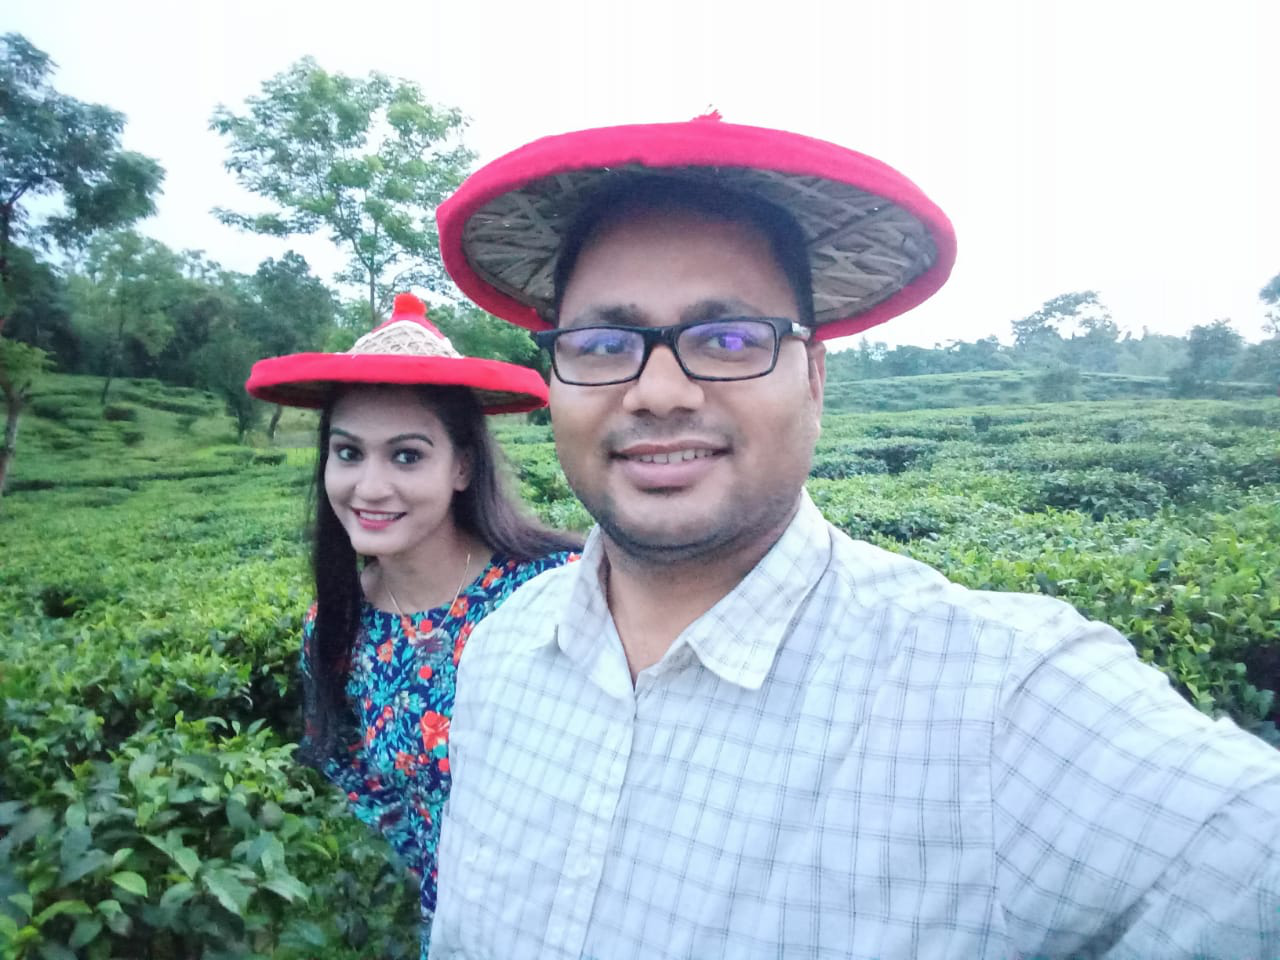

In [0]:
image_path = '/content/Neha.jpg'
PIL.Image.open(image_path)


In [0]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

In [0]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

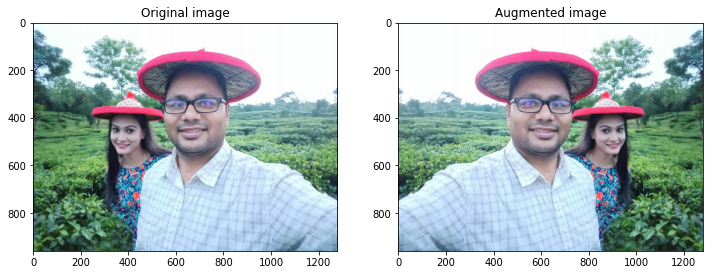

In [0]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

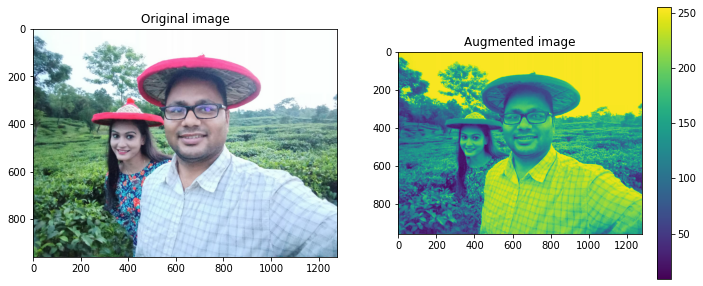

In [0]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

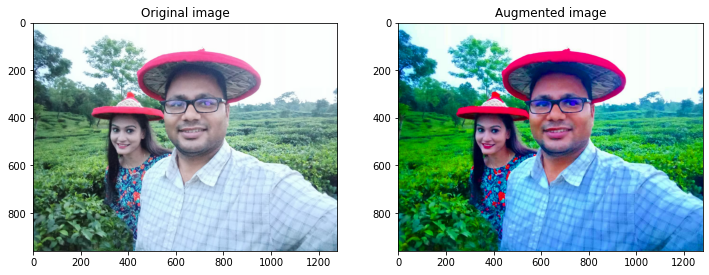

In [0]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

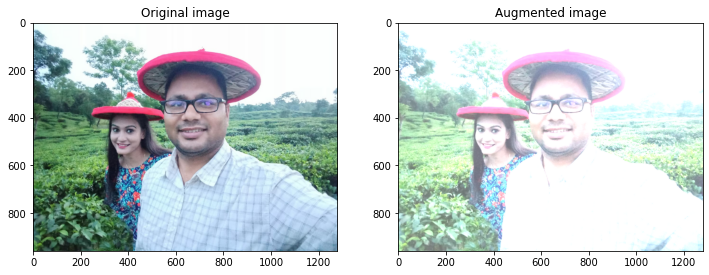

In [0]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

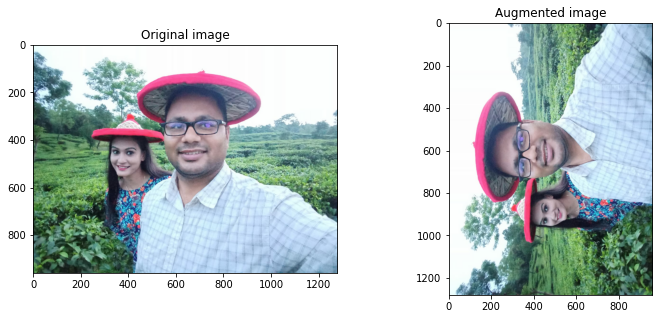

In [0]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

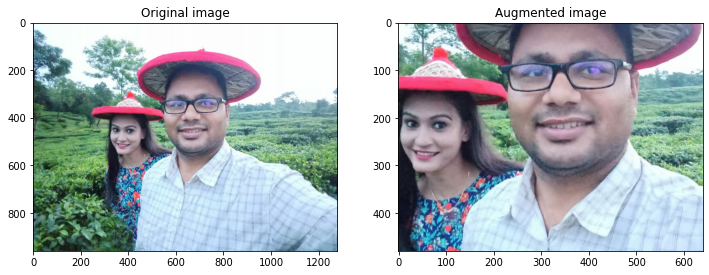

In [0]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

In [0]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [0]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [0]:
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [0]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [0]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [0]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 17s 525ms/step - loss: 0.7804 - accuracy: 0.7632 - val_loss: 0.3950 - val_accuracy: 0.8842
Epoch 2/50
32/32 [==============================] - 17s 522ms/step - loss: 0.1895 - accuracy: 0.9448 - val_loss: 0.3277 - val_accuracy: 0.9071
Epoch 3/50
32/32 [==============================] - 17s 518ms/step - loss: 0.0741 - accuracy: 0.9746 - val_loss: 0.3144 - val_accuracy: 0.9159
Epoch 4/50
32/32 [==============================] - 17s 525ms/step - loss: 0.0460 - accuracy: 0.9844 - val_loss: 0.3446 - val_accuracy: 0.9191
Epoch 5/50
32/32 [==============================] - 17s 526ms/step - loss: 0.0531 - accuracy: 0.9834 - val_loss: 0.3942 - val_accuracy: 0.9125
Epoch 6/50
32/32 [==============================] - 17s 523ms/step - loss: 0.0255 - accuracy: 0.9937 - val_loss: 0.3330 - val_accuracy: 0.9267
Epoch 7/50
32/32 [==============================] - 17s 522ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.3222 - val_accuracy: 0.9325

In [0]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 17s 526ms/step - loss: 2.4725 - accuracy: 0.2783 - val_loss: 1.3291 - val_accuracy: 0.6309
Epoch 2/50
32/32 [==============================] - 17s 527ms/step - loss: 1.4528 - accuracy: 0.5181 - val_loss: 0.7351 - val_accuracy: 0.7855
Epoch 3/50
32/32 [==============================] - 17s 523ms/step - loss: 1.0412 - accuracy: 0.6592 - val_loss: 0.5384 - val_accuracy: 0.8612
Epoch 4/50
32/32 [==============================] - 17s 521ms/step - loss: 0.8475 - accuracy: 0.7178 - val_loss: 0.4265 - val_accuracy: 0.8781
Epoch 5/50
32/32 [==============================] - 17s 521ms/step - loss: 0.7546 - accuracy: 0.7432 - val_loss: 0.3788 - val_accuracy: 0.8831
Epoch 6/50
32/32 [==============================] - 17s 522ms/step - loss: 0.5856 - accuracy: 0.8076 - val_loss: 0.3457 - val_accuracy: 0.8825
Epoch 7/50
32/32 [==============================] - 17s 525ms/step - loss: 0.5545 - accuracy: 0.8232 - val_loss: 0.2995 - val_accuracy: 0.9075

In [0]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

In [0]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])